# PID Control of pH in a CSTR

CBE 30338 Chemical Process Control - Final Project by Sarah Antico, Emily Mount, and Caroline Tracey
<br/><br/>


<font size="4">**Introduction and Problem Statement**</font>

Chemical process control involves monitoring and manipulating several variables (temperature, pressure, humidity, etc) in real time. The most commonly used method to control these variables and maintain a setpoint in industry using feedback is Proportional-Integral-Derivative (PID) Control. This method involves implementing a controller that measures process variables and manipulates the system by following the equation  below (written in velocity form): 

\begin{align}
MV_k & = \overline{MV} + K_P e_k  + K_I \sum_{k'=0}^k e_{k'}(t_k - t_{k-1}) + K_D \frac{e_k - e_{k-1}}{t_k - t_{k-1}}
\end{align}<div style="text-align: right"> (1) </div>

where $MV_k$ is the manipulated variable at time $t = k$, $\overline{MV}$ is an initial estimate of the manipulated variable (also called the offset), $K_P$, $K_I$, and $K_D$ are constants, $t_k$ is the sampling time, and $e_k$ is the difference between setpoint and measured process variable:

\begin{align}
e_k = SP_k - PV_k
\end{align}<div style="text-align: right"> (2) </div>

The purpose of each term in the PID Control equation is below:

**Proportional**: The controller computes the difference between a process variable and its setpoint (the error signal defined above) and adjusts the manipulated variable in proportion to this time-dependent value with a constant proportional control gain, $K_p$, in attempt to approach the setpoint. 

**Integral**: This term computes the error as it changes over time, uses this past error as an approximation for future error, and attempts to counteract this offset error proportional to a distinct gain parameter, the integral gain $K_I$. 

**Derivative**: The derivative term serves to predict future error. As the name suggests, this term computes the change in the slope of the error over time and multiplies this by a third gain constant, the derivative gain $K_D$. 

These proportionality constants for each term can be set in a number of ways - from "guessing and checking" to employing a set of tuning rules from a particular method. Several well-known tuning methods exist which often provide an expression for each proportionality constant in terms of gain $K$, process time constant $T$, and process time delay $\tau$ (all found empirically).

One of the most important variables for systems in the chemical industry and beyond is pH. A pH outside of the desired range can corrode pipes, create safety hazards, have adverse environmental impacts, and create inconsistencies in products depending on the application. pH control is crucial for the safety of products in the cosmetic industry, drugs in the pharmaceutical industry, the production of food and beverages, in manufacturing to not destroy pipes/vats, treatment of effluent streams to be released into the enironment, and of course the collection and treatment of wastewater as explored here. The U.S. Environmental Protection Agency (EPA) recommends that local governments adopt laws to maintain water systems to a range of 6.5 to 8.5 for pH for safety. 

For most processes, a pH of 7 (a neutral solution) is preferred. pH control is especially difficult because it is defined by a logarithmic relationship with hyrdrogen ion concentration (the manipulated variable): 

\begin{align}
pH = -log[H^+]
\end{align} <div style="text-align: right"> (3) </div>

The goal of this project was to design a PID controller for the pH of a continuous stirred tank reactor (CSTR) at a wastewater faciility and compare several tuning methods. Disturbances include influxes of wastewater which has often unpredictable pH values and manipulation of the system was done through adding acid or base to the tank to maintain a neutral setpoint. A CSTR is used so that pH is considered uniform throughout the system and any system changes occur virtually instantaneously. A diagram of the system is show below:

<img src="pidphpic.png" alt="drawing" width="400"/>

The following cells show the PID controller implemented to simulate this problem and their simulated outputs.

<font size="4">**Import Libraries**</font>

In [2]:
!pip install tclab
!pip install pHcalc
%matplotlib inline
from tclab import clock, setup, Historian, Plotter
from pHcalc.pHcalc import Acid, Neutral, System
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.optimize import least_squares

<font size="4">**Create function for PID control**</font>
- takes inputs of the proportionality constants and an initial estimate of the manipulated variable

In [3]:
def PID(Kp, Ki, Kd, MV_bar=0):
    # initialize stored data
    e_prev = 0
    t_prev = -100
    I = 0
    
    # initial control
    MV = MV_bar
    
    while True:
        # yield MV, wait for new t, PV, SP
        t, PV, SP = yield MV
        
        # PID calculations
        e = SP - PV
        
        P = Kp*e
        I = I + Ki*e*(t - t_prev)
        D = Kd*(e - e_prev)/(t - t_prev)
        
        MV = MV_bar + P + I + D
        
        # update stored data for next iteration
        e_prev = e
        t_prev = t

<font size="4">**Create function to simulate measurement of pH in CSTR**</font>
- Inputs of wastewater disturbance flow and initial pH measurement. Outputs necessary flowrate of acid/base to neutralize system

In [4]:
def pH(WasteFlow,pHreturn, LOUD = False):
    concH = 10^-(pHreturn)
    
    if pHreturn < 7:
        addbase = 7 - pHreturn
        addbaseConc = WasteFlow*addbase
        if LOUD:
            print('Must add: ', addbaseConc,' M of base at ', WasteFlow, 'L/h to neutralize waste flow.')
    if pHreturn > 7:
        addacid = pHreturn - 7
        addacidConc = WasteFlow*addacid
        if LOUD:
            print('Must add: ', addacidConc,' M of acid at ', WasteFlow, 'L/h to neutralize waste flow.')
            
pH(10,5, LOUD = True)

Must add:  20  M of base at  10 L/h to neutralize waste flow.


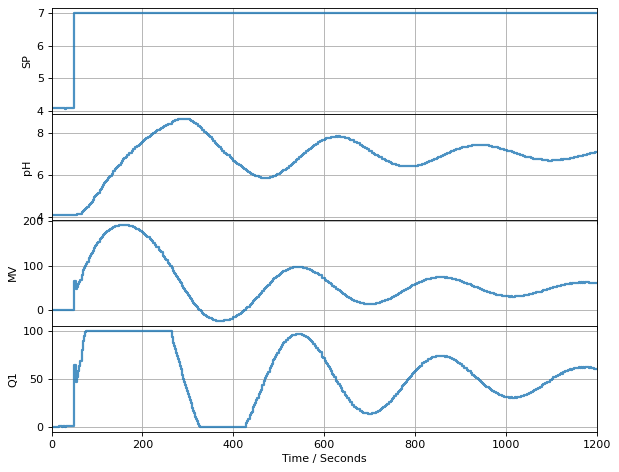

TCLab Model disconnected successfully.


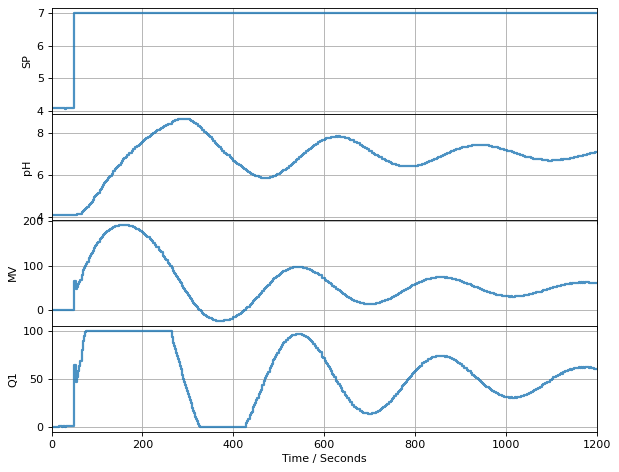

In [5]:
TCLab = setup(connected=False, speedup=20)

controller = PID(1, 0.1, 2)        # create PID controller
controller.send(None)              # initialize

tfinal = 1200  # seconds

SP = 21
with TCLab() as lab:
    SP = 21
    h = Historian([('SP', lambda: 2+ SP/10), ('pH', lambda: 2+ lab.T1/10), ('MV', lambda: MV), ('Q1', lab.Q1)])
    p = Plotter(h, tfinal)
    T1 = lab.T1
    for t in clock(tfinal, 2):
        SP = lab.T1 if t < 50 else 50           # get setpoint
        PV = lab.T1                         # get measurement
        MV = controller.send([t, PV, SP])   # compute manipulated variable
        lab.U1 = MV                         # apply 
        p.update(t)

    h.to_csv('PIDLab1.csv')

In [6]:
expt = pd.read_csv('PIDLab1.csv')
expt.index = expt['Time']

<font size="4">**Plot Results**</font>
- Plots pH measurement, pH prediction, residuals, and flow rate of acid or base needed

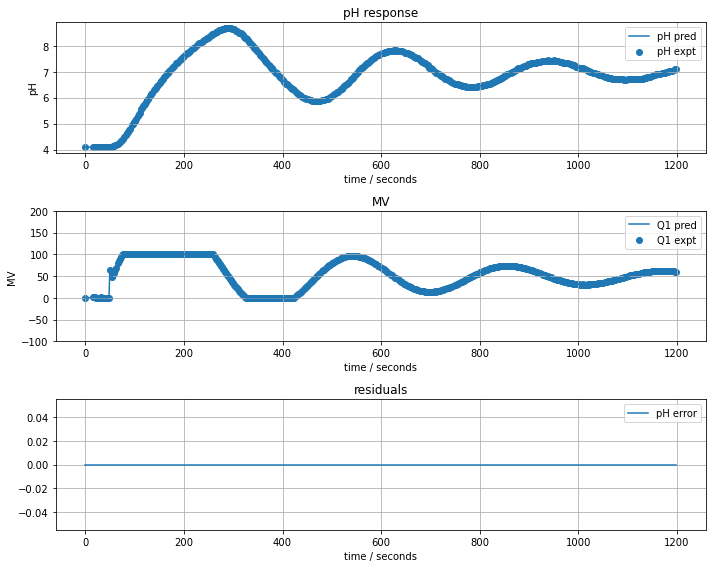

In [7]:
def plot_data(expt, pred):
    t_expt = expt.index
    
    # create a 3 x 1 grid of plot axes
    fig, ax = plt.subplots(3, 1, figsize=(10,8))
    
    # first plot axes
    ax[0].scatter(t_expt, expt["pH"], label="pH expt")
    ax[0].plot(t_expt, pred["pH"], label="pH pred")
    ax[0].set_ylabel("pH")
    ax[0].set_title("pH response")

    # second plot axes
    ax[1].scatter(t_expt, expt["Q1"], label="Q1 expt")
    ax[1].plot(t_expt, pred["Q1"], label="Q1 pred")
    ax[1].set_ylim([-100, 200])
    ax[1].set_ylabel("MV")
    ax[1].set_title("MV")
    
    # third plot axes
    ax[2].plot(t_expt, pred["pH"]-expt["pH"], label="pH error")
    ax[2].set_title("residuals")
    
    # things to do for every plot axes
    for a in ax:
        a.grid(True)
        a.set_xlabel("time / seconds")
        a.legend()
        
    plt.tight_layout()
    
    return
    
# demonstrate by comparing experimental data to itself
plot_data(expt, expt);

Time
0.00       0.005050
16.01      0.130370
18.03      0.171377
20.04      0.211635
22.04      0.251162
             ...   
1188.02    0.261757
1190.01    0.261773
1194.03    0.229575
1196.01    0.197361
1198.03    0.197377
Name: pH, Length: 494, dtype: float64

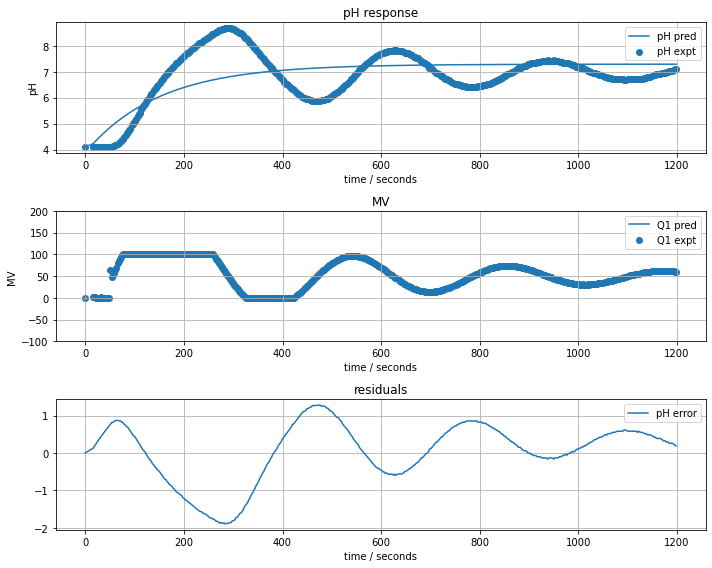

In [8]:
# parameter values and units
pAmb = 21                 
u1bar = expt["Q1"].mean()
t_expt = expt.index

# adjustable parameters
K = 0.6
tau = 150
t_delay = 10

def model_first_order_delay(param, plot=False):
    K, tau, t_delay = param    
    pred = pd.DataFrame(columns=["pH","Q1"], index=t_expt)
    pred["pH"] = [2+(pAmb + K*u1bar*(1 - np.exp(-(t-t_delay)/tau)))/10 if t > t_delay else 2+pAmb/10 for t in t_expt]
    if plot:
        plot_data(expt, pred)
    return pred["pH"] - expt["pH"]
    
model_first_order_delay([K, tau, t_delay], True)

<font size="4">**Implementation of Tuning Methods**</font>

The cells above include adjustable values for the proportionality constants, time delay, and process time constant. The remaining cells use the same PID controller above but implement the following respective tuning methods: Ziegler-Nichols, Relay tuning, and Cohen-Coon through functions which take inputs of gain, time delay, and time constant.

<font size="4">**Zeigler-Nichols**</font>

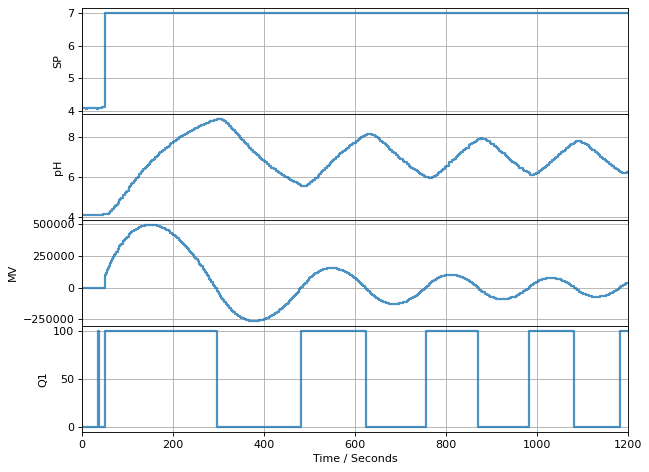

TCLab Model disconnected successfully.


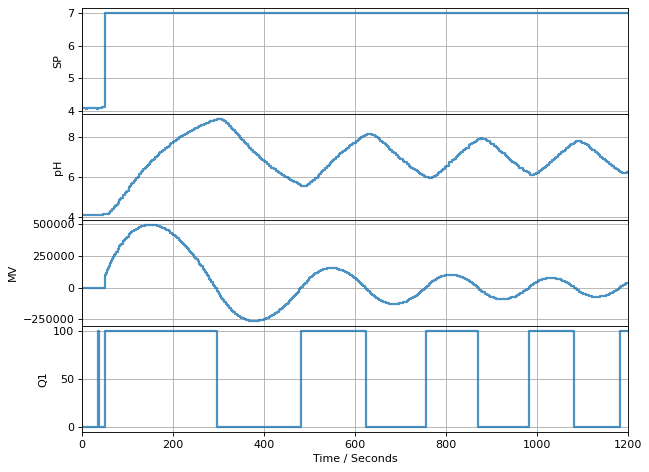

In [9]:
# Ziegler-Nichols tuning model

def PID_params(params):
    K, T, tau = params
    Kp = 1.2*(T/K*tau)
    Ki = 2*tau
    Kd = 0.5*tau

    return Kp, Ki, Kd

Kp, Ki, Kd = PID_params((K, t_delay, tau))
print(Kp, Ki, Kd)

controller = PID(Kp, Ki, Kd)        # create pid control
controller.send(None)              # initialize

tfinal = 1200  # seconds

SP = 21

with TCLab() as lab:
    SP = 21
    h = Historian([('SP', lambda: 2+ SP/10), ('pH', lambda: 2+ lab.T1/10), ('MV', lambda: MV), ('Q1', lab.Q1)])
    p = Plotter(h, tfinal)
    T1 = lab.T1
    for t in clock(tfinal, 2):
        SP = lab.T1 if t < 50 else 50           # get setpoint
        PV = lab.T1                         # get measurement
        MV = controller.send([t, PV, SP])   # compute manipulated variable
        lab.U1 = MV                         # apply 
        p.update(t)

    h.to_csv('PIDLab2.csv')

<font size="4">**Relay Tuning**</font>

In [10]:
# Relay tuning method
def relay(SP, a = 5):
    MV = 0
    while True:
        PV = yield MV
        MV_prev = MV
        MV = 100 if PV < SP - a else 0 if PV > SP + a else MV_prev

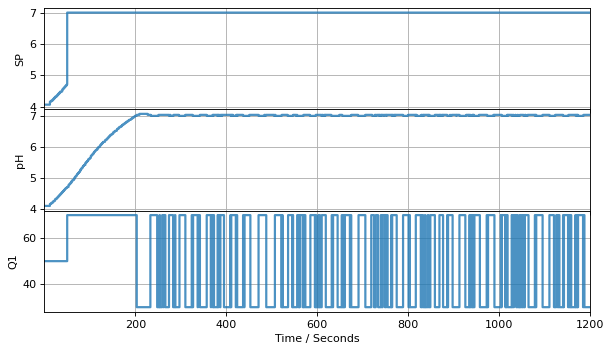

TCLab Model disconnected successfully.


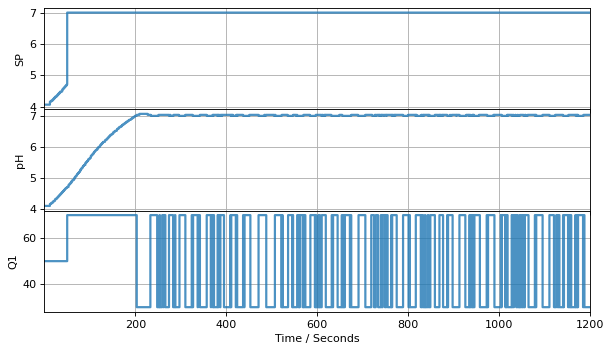

In [13]:
TCLab = setup(connected=False, speedup=20)

tfinal = 1200    # seconds
MV_bar = 50
hMV = 20

SP = 21

with TCLab() as lab:
    h = Historian([('SP', lambda: 2+ SP/10), ('pH', lambda: 2+lab.T1/10), ('Q1', lab.Q1)])
    p = Plotter(h, tfinal)
    T1 = lab.T1
    for t in clock(tfinal, 1):
        if t < 50:
            SP = lab.T1
            MV = MV_bar
            
        else:
            SP = 50
            MV = (MV_bar - hMV) if (lab.T1 > SP) else (MV_bar + hMV)
        lab.Q1(MV)
        p.update(t)                                   # update information display
        h.to_csv('PIDLab4.csv')

<font size="4">**Cohen-Coon**</font>

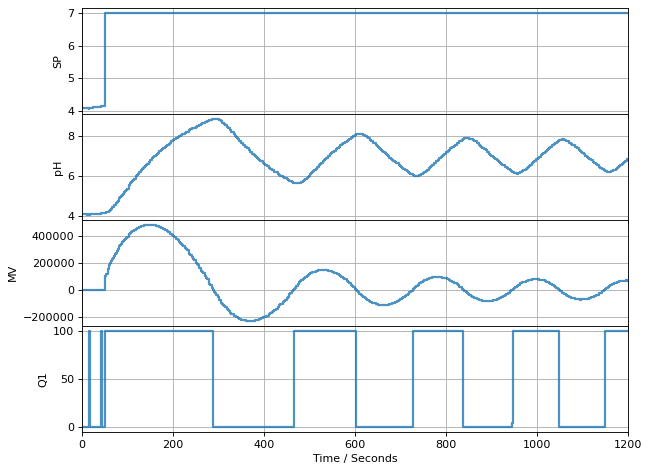

TCLab Model disconnected successfully.


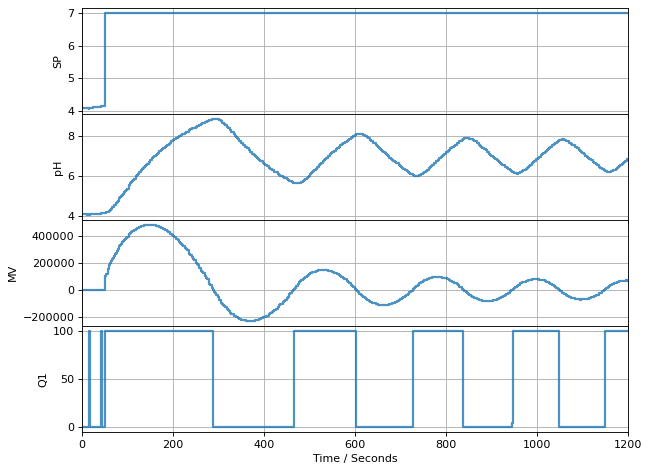

In [12]:
def PID_paramsCC(params):
    K, T, tau = params
    Kp = (T/K*tau)*(1.33+((tau/T)/4))
    Ki = (tau*(30+(3*(tau/T))))/(9+(20*(tau/T)))
    Kd = (4*tau)/(11+(2*(tau/T)))

    return Kp, Ki, Kd

Kp, Ki, Kd = PID_params((K, t_delay, tau))
print(Kp, Ki, Kd)

controller = PID(Kp, Ki, Kd)        # create pid control
controller.send(None)              # initialize

tfinal = 1200   # seconds

SP = 21

with TCLab() as lab:
    SP = 21
    h = Historian([('SP', lambda: 2+ SP/10), ('pH', lambda: 2+ lab.T1/10), ('MV', lambda: MV), ('Q1', lab.Q1)])
    p = Plotter(h, tfinal)
    T1 = lab.T1
    for t in clock(tfinal, 2):
        SP = lab.T1 if t < 50 else 50       # get setpoint
        PV = lab.T1                         # get measurement
        MV = controller.send([t, PV, SP])   # compute manipulated variable
        lab.U1 = MV                         # apply 
        p.update(t)

    h.to_csv('PIDLab3.csv')

<font size="4">**Comparison of Tuning Methods**</font>

Each method was successfully able to monitor the pH to and approach a setpoint, although the ranges of pH for a given model may vary with different disturbances. To summarize the results for each model:

**Zeigler-Nichols**: <br/>
- aggressive model that overshoots the setpoint <br/>
- reaches the setpoint fastest <br/>
- large fluctuations around the setpoint <br/>
 
**Cohen-Coon**:<br/>
- aggressive model that overshoots the setpoint <br/>
- reaches the setpoint the second fastest<br/>

**Relay/Auto-tuning**:<br/>
- reaches the setpoint last<br/>
- does not noticeably overshoot the setpoint<br/>
- minimal fluctuations around the setpoint (stabilizes the pH the best)<br/>

<font size="4">**Conclusion**</font>

After testing each tuning method for 1200 seconds (20 minutes) with the same disturbance, we have determined that Relay tuning reaches the setpoint with the least amount of deviations from the setpoint although it does require rapidly and frequently manipulating the system by adding acid and base. It does not have large overshoots. Zeigler-Nichols reaches the setpoint fastest, but is an aggressive model that overshoots the setpoint. Relay's minimized deviations from the setpoint implies that it is the best at stabilizing pH in response to rapid pH disturbance.

Thus, based on our results we would recommmend using Relay tuning for practical use.

<font size="4">**References**</font>

Aström, K. J., & Murray, R. M. (2010). Feedback Systems: An Introduction for Scientists and Engineers. Princeton University Press.

Bingi, Kishore & Ibrahim, Rosdiazli & Karsiti, Mohd & Chung, Tran & Hassan, Sabo. (2016). Optimal PID control of pH neutralization plant. 1-6. 10.1109/ROMA.2016.7847812. 

Bingi, R. Ibrahim, M. N. Karsiti, T. D. Chung and S. M. Hassan, "Optimal PID control of pH neutralization plant," 2016 2nd IEEE International Symposium on Robotics and Manufacturing Automation (ROMA), Ipoh, Malaysia, 2016, pp. 1-6, doi: 10.1109/ROMA.2016.7847812.

EPA, Drinking Water Regulations and Contaminants, https://www.epa.gov/sdwa/drinking-water-regulations-and-contaminants.

F.J. Hurtado, A.S. Kaiser, B. Zamora, Fluid dynamic analysis of a continuous stirred tank reactor for technical optimization of wastewater digestion, Water Research, Volume 71, 2015, Pages 282-293, ISSN 0043-1354, https://doi.org/10.1016/j.watres.2014.11.053. (https://www.sciencedirect.com/science/article/pii/S004313541400832X)

Kantor, Jeffrey. CBE-30338-2021, (2021), GitHub repository, https://github.com/jckantor/cbe30338-2021. 

pH Control, General Cybernation Group, 2021, www.cybosoft.com/solutions/phcontrol.html.

Wastewater Treatment Water Use. (n.d.). USGS. https://www.usgs.gov/special-topic/water-science-school/science/wastewater-treatment-water-use?qt-science_center_objects=0#qt-science_center_objects

Woolf, Peter. P, I, D, PI, PD, and PID Control. University of Michigan, 5 Mar. 2021, https://eng.libretexts.org/@go/page/22412.